In [1]:
import os
from torchvision import datasets, transforms


cwd = os.getcwd()
print("1) Current working dir:", cwd)
print("2) CWD contents:", os.listdir(cwd))
data_dir = "images"
abs_data_dir = os.path.abspath(data_dir)
print("3) data_dir resolved to:", abs_data_dir)
print("4) data_dir exists?", os.path.isdir(abs_data_dir))
print("5) inside data_dir:", os.listdir(abs_data_dir) if os.path.isdir(abs_data_dir) else "—")

try:
    ds = datasets.ImageFolder(os.path.join(data_dir, 'train'))
    print("OK, found", len(ds.classes), "classes:", ds.classes)
except Exception as e:
    print("Error loading ImageFolder:", e)


1) Current working dir: /Users/amycai/Documents/stat 453/project
2) CWD contents: ['lenetbn_best.pth', 'lenet5_finetuned.pth', '.DS_Store', 'fer_cnn.pth', 'presentation-instructions.pptx', 'images', 'Untitled.ipynb', 'STAT 405 Proposal.pdf', 'amy.html', 'images 2', 'simplefer_fixed.pth', 'Moshi.ipynb', 'samples', 'DS_Store', 'STAT 453 project.pdf', 'lenet_fer.pth', 'samll cnn.ipynb', 'sample-student-project-report.pdf', '.ipynb_checkpoints', 'Augmented_data.py', 'archive.zip', 'convbnfer_fer.pth']
3) data_dir resolved to: /Users/amycai/Documents/stat 453/project/images
4) data_dir exists? True
5) inside data_dir: ['images', 'train', 'validation']
OK, found 7 classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20
batch_size = 64
lr         = 1e-3

transform = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),                       # [0,1]
    transforms.Normalize([0.5], [0.5])           # [-1,1]
])

data_dir    = 'images'
train_ds    = datasets.ImageFolder(os.path.join(data_dir, 'train'),      transform=transform)
val_ds      = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform=transform)
train_loader= DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader  = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4)
num_classes = len(train_ds.classes)

class SmallCNN4(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1,  32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128,256, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)
        self.pool  = nn.MaxPool2d(2,2)
        self.classifier = nn.Sequential(
            nn.Flatten(),                  # 256×3×3 → 2304
            nn.Linear(256*3*3, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)   # logits 输出
        )

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))  # 48→24
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))  # 24→12
        x = self.pool(nn.ReLU()(self.bn3(self.conv3(x))))  # 12→6
        x = self.pool(nn.ReLU()(self.bn4(self.conv4(x))))  # 6→3
        return self.classifier(x)

model = SmallCNN4(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = correct = total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds       = logits.argmax(dim=1)
        correct    += (preds == labels).sum().item()
        total      += imgs.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total

    model.eval()
    val_correct = val_total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total   += labels.size(0)
    val_acc = val_correct / val_total

    scheduler.step()
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch 01 | Train Loss: 1.7437 | Train Acc: 0.2935 | Val Acc: 0.3943
Epoch 02 | Train Loss: 1.4832 | Train Acc: 0.4207 | Val Acc: 0.4686
Epoch 03 | Train Loss: 1.3810 | Train Acc: 0.4659 | Val Acc: 0.5023
Epoch 04 | Train Loss: 1.3239 | Train Acc: 0.4876 | Val Acc: 0.4979
Epoch 05 | Train Loss: 1.2825 | Train Acc: 0.5054 | Val Acc: 0.5381
Epoch 06 | Train Loss: 1.2162 | Train Acc: 0.5359 | Val Acc: 0.5592
Epoch 07 | Train Loss: 1.1820 | Train Acc: 0.5509 | Val Acc: 0.5698
Epoch 08 | Train Loss: 1.1610 | Train Acc: 0.5599 | Val Acc: 0.5757
Epoch 09 | Train Loss: 1.1440 | Train Acc: 0.5671 | Val Acc: 0.5662
Epoch 10 | Train Loss: 1.1246 | Train Acc: 0.5713 | Val Acc: 0.5764
Epoch 11 | Train Loss: 1.0766 | Train Acc: 0.5919 | Val Acc: 0.5897
Epoch 12 | Train Loss: 1.0524 | Train Acc: 0.6052 | Val Acc: 0.5972
Epoch 13 | Train Loss: 1.0426 | Train Acc: 0.6061 | Val Acc: 0.5988
Epoch 14 | Train Loss: 1.0303 | Train Acc: 0.6121 | Val Acc: 0.6005
Epoch 15 | Train Loss: 1.0172 | Train Acc: 0.617

Loaded 71774 images


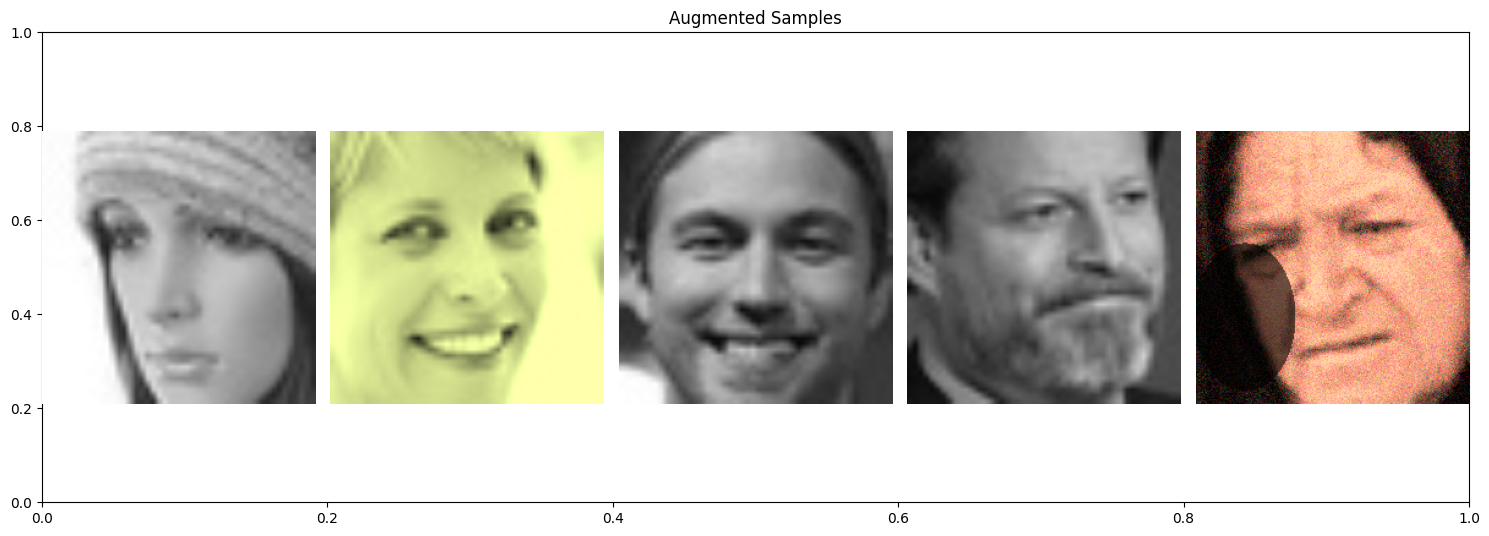

Saved batch 0 with 8 images
Saved batch 1 with 8 images
Saved batch 2 with 8 images
Saved batch 3 with 8 images
Saved batch 4 with 8 images
Saved batch 5 with 8 images
Saved batch 6 with 8 images
Saved batch 7 with 8 images
Saved batch 8 with 8 images
Saved batch 9 with 8 images
Saved batch 10 with 8 images
Saved batch 11 with 8 images
Saved batch 12 with 8 images
Saved batch 13 with 8 images
Saved batch 14 with 8 images
Saved batch 15 with 8 images
Saved batch 16 with 8 images
Saved batch 17 with 8 images
Saved batch 18 with 8 images
Saved batch 19 with 8 images
Saved batch 20 with 8 images
Saved batch 21 with 8 images
Saved batch 22 with 8 images
Saved batch 23 with 8 images
Saved batch 24 with 8 images
Saved batch 25 with 8 images
Saved batch 26 with 8 images
Saved batch 27 with 8 images
Saved batch 28 with 8 images
Saved batch 29 with 8 images
Saved batch 30 with 8 images
Saved batch 31 with 8 images
Saved batch 32 with 8 images
Saved batch 33 with 8 images
Saved batch 34 with 8 im

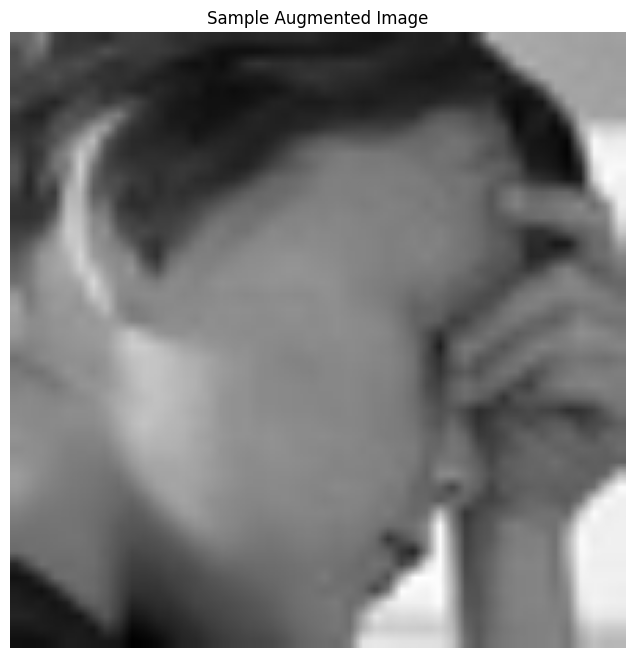

In [7]:
%run Augmented_data.py

In [7]:
#small cnn -3
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20
batch_size = 64
lr         = 1e-3

data_dir   = 'augmented_data/images'
train_dir  = os.path.join(data_dir, 'train')
val_dir    = os.path.join(data_dir, 'validation')

transform = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),                        # [0,1]
    transforms.Normalize(mean=[0.5], std=[0.5])   # [-1,1]
])

train_ds = datasets.ImageFolder(root=train_dir, transform=transform)
val_ds   = datasets.ImageFolder(root=val_dir,   transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4)

num_classes = len(train_ds.classes)

class SmallCNN3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1,  32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                        
            nn.Linear(128*6*6, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return self.classifier(x)

model_3 = SmallCNN3(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3.parameters(), lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

for epoch in range(1, num_epochs+1):
    model_3.train()
    running_loss = correct = total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model_3(imgs)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds       = logits.argmax(dim=1)
        correct    += (preds == labels).sum().item()
        total      += imgs.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total

    model_3.eval()
    val_loss = correct = total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model_3(imgs)
            loss   = criterion(logits, labels)

            val_loss += loss.item() * imgs.size(0)
            preds    = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += imgs.size(0)

    val_loss /= total
    val_acc   = correct / total

    scheduler.step()

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f" Val Loss: {val_loss:.4f},  Val Acc: {val_acc:.4f}")


Epoch 01 | Train Loss: 1.8297, Train Acc: 0.2490 |  Val Loss: 1.7186,  Val Acc: 0.3027
Epoch 02 | Train Loss: 1.6879, Train Acc: 0.3134 |  Val Loss: 1.5562,  Val Acc: 0.4080
Epoch 03 | Train Loss: 1.6018, Train Acc: 0.3572 |  Val Loss: 1.5048,  Val Acc: 0.4275
Epoch 04 | Train Loss: 1.5634, Train Acc: 0.3754 |  Val Loss: 1.4498,  Val Acc: 0.4472
Epoch 05 | Train Loss: 1.5364, Train Acc: 0.3847 |  Val Loss: 1.4350,  Val Acc: 0.4389
Epoch 06 | Train Loss: 1.4999, Train Acc: 0.3995 |  Val Loss: 1.3951,  Val Acc: 0.4653
Epoch 07 | Train Loss: 1.4727, Train Acc: 0.4153 |  Val Loss: 1.3748,  Val Acc: 0.4689
Epoch 08 | Train Loss: 1.4610, Train Acc: 0.4160 |  Val Loss: 1.3849,  Val Acc: 0.4731
Epoch 09 | Train Loss: 1.4549, Train Acc: 0.4184 |  Val Loss: 1.3524,  Val Acc: 0.4983
Epoch 10 | Train Loss: 1.4337, Train Acc: 0.4306 |  Val Loss: 1.3305,  Val Acc: 0.4942
Epoch 11 | Train Loss: 1.4140, Train Acc: 0.4372 |  Val Loss: 1.3053,  Val Acc: 0.5110
Epoch 12 | Train Loss: 1.4083, Train Acc: 0

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 25
batch_size = 64
lr         = 1e-3

transform = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

data_dir    = 'augmented_data/images'
train_ds    = datasets.ImageFolder(os.path.join(data_dir, 'train'),      transform)
val_ds      = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform)
train_loader= DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader  = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4)
num_classes = len(train_ds.classes)

class SmallCNN5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1,  32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True), nn.MaxPool2d(2)
        )  # 48→24
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True), nn.MaxPool2d(2)
        )  # 24→12
        self.block3 = nn.Sequential(
            nn.Conv2d(64,128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True), nn.MaxPool2d(2)
        )  # 12→6
        self.block4 = nn.Sequential(
            nn.Conv2d(128,256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True), nn.MaxPool2d(2)
        )  # 6→3
        self.block5 = nn.Sequential(
            nn.Conv2d(256,512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                  # 512×3×3 → 4608
            nn.Linear(512*3*3, 512),      nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        return self.classifier(x)

model_5 = SmallCNN5(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_5.parameters(), lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

for epoch in range(1, num_epochs+1):
    model_5.train()
    train_loss = correct = total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model_5(imgs)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        preds      = logits.argmax(dim=1)
        correct   += (preds == labels).sum().item()
        total     += imgs.size(0)

    train_loss /= total
    train_acc  = correct / total

    model_5.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model_5(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    val_acc = correct / total

    scheduler.step()
    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")



Epoch 01 | Train Loss: 1.7624 | Train Acc: 0.2840 | Val Acc: 0.3565
Epoch 02 | Train Loss: 1.5378 | Train Acc: 0.3932 | Val Acc: 0.4553
Epoch 03 | Train Loss: 1.4399 | Train Acc: 0.4371 | Val Acc: 0.4832
Epoch 04 | Train Loss: 1.3754 | Train Acc: 0.4689 | Val Acc: 0.4967
Epoch 05 | Train Loss: 1.3291 | Train Acc: 0.4911 | Val Acc: 0.5151
Epoch 06 | Train Loss: 1.3002 | Train Acc: 0.5065 | Val Acc: 0.5304
Epoch 07 | Train Loss: 1.2601 | Train Acc: 0.5231 | Val Acc: 0.5209
Epoch 08 | Train Loss: 1.1759 | Train Acc: 0.5588 | Val Acc: 0.5402
Epoch 09 | Train Loss: 1.1347 | Train Acc: 0.5726 | Val Acc: 0.5674
Epoch 10 | Train Loss: 1.0983 | Train Acc: 0.5869 | Val Acc: 0.5712
Epoch 11 | Train Loss: 1.0656 | Train Acc: 0.6017 | Val Acc: 0.5808
Epoch 12 | Train Loss: 1.0396 | Train Acc: 0.6093 | Val Acc: 0.5817
Epoch 13 | Train Loss: 1.0066 | Train Acc: 0.6240 | Val Acc: 0.5882
Epoch 14 | Train Loss: 0.9758 | Train Acc: 0.6292 | Val Acc: 0.5814
Epoch 15 | Train Loss: 0.9014 | Train Acc: 0.663

In [1]:
# 4 layers
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20
batch_size = 64
lr         = 1e-3

transform = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),                       # [0,1]
    transforms.Normalize([0.5], [0.5])           # [-1,1]
])

data_dir    = 'augmented_data/images'
train_ds    = datasets.ImageFolder(os.path.join(data_dir, 'train'),      transform=transform)
val_ds      = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform=transform)
train_loader= DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader  = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4)
num_classes = len(train_ds.classes)

class SmallCNN4(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1,  32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128,256, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)
        self.pool  = nn.MaxPool2d(2,2)
        self.classifier = nn.Sequential(
            nn.Flatten(),                  # 256×3×3 → 2304
            nn.Linear(256*3*3, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)   # logits 输出
        )

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))  # 48→24
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))  # 24→12
        x = self.pool(nn.ReLU()(self.bn3(self.conv3(x))))  # 12→6
        x = self.pool(nn.ReLU()(self.bn4(self.conv4(x))))  # 6→3
        return self.classifier(x)

model = SmallCNN4(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = correct = total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds       = logits.argmax(dim=1)
        correct    += (preds == labels).sum().item()
        total      += imgs.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total

    model.eval()
    val_correct = val_total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total   += labels.size(0)
    val_acc = val_correct / val_total

    scheduler.step()
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch 01 | Train Loss: 1.7919 | Train Acc: 0.2634 | Val Acc: 0.3415
Epoch 02 | Train Loss: 1.5697 | Train Acc: 0.3803 | Val Acc: 0.4389
Epoch 03 | Train Loss: 1.4799 | Train Acc: 0.4165 | Val Acc: 0.4383
Epoch 04 | Train Loss: 1.4150 | Train Acc: 0.4478 | Val Acc: 0.4929
Epoch 05 | Train Loss: 1.3711 | Train Acc: 0.4684 | Val Acc: 0.4922
Epoch 06 | Train Loss: 1.3165 | Train Acc: 0.4911 | Val Acc: 0.5248
Epoch 07 | Train Loss: 1.2905 | Train Acc: 0.5040 | Val Acc: 0.5030
Epoch 08 | Train Loss: 1.2663 | Train Acc: 0.5159 | Val Acc: 0.5378
Epoch 09 | Train Loss: 1.2501 | Train Acc: 0.5220 | Val Acc: 0.5463
Epoch 10 | Train Loss: 1.2328 | Train Acc: 0.5223 | Val Acc: 0.5491
Epoch 11 | Train Loss: 1.1935 | Train Acc: 0.5427 | Val Acc: 0.5638
Epoch 12 | Train Loss: 1.1780 | Train Acc: 0.5502 | Val Acc: 0.5548
Epoch 13 | Train Loss: 1.1633 | Train Acc: 0.5570 | Val Acc: 0.5651
Epoch 14 | Train Loss: 1.1540 | Train Acc: 0.5618 | Val Acc: 0.5592
Epoch 15 | Train Loss: 1.1344 | Train Acc: 0.566

In [18]:
import numpy as np
import pandas as pd
from scipy import stats

results = {
    '3‑CNN': [0.5263, 0.5225, 0.5250, 0.5328, 0.5314],
    '4‑CNN': [0.5753, 0.5676, 0.5715, 0.5729, 0.5671],
    '5‑CNN': [0.6008, 0.5938, 0.5971, 0.6077, 0.6026],
}

summary_list = []
for name, acc_list in results.items():
    arr = np.array(acc_list)
    desc = pd.Series(arr).describe()    
    sem     = stats.sem(arr)           
    ci95    = sem * 1.96               

    summary_list.append({
        'Model':         name,
        'Mean (%)':      f"{desc['mean']*100:.1f}",
        'Std (%)':       f"{desc['std']*100:.1f}",
        'SEM (%)':       f"{sem*100:.1f}",
        '95% CI ± (%)':  f"{ci95*100:.1f}",
        'Min (%)':       f"{desc['min']*100:.1f}",
        'Median (%)':    f"{desc['50%']*100:.1f}",
        'Max (%)':       f"{desc['max']*100:.1f}",
    }) 

# 3. Create DataFrame and print
df_summary = pd.DataFrame(summary_list)
print(df_summary.to_string(index=False))


Model Mean (%) Std (%) SEM (%) 95% CI ± (%) Min (%) Median (%) Max (%)
3‑CNN     52.8     0.4     0.2          0.4    52.2       52.6    53.3
4‑CNN     57.1     0.4     0.2          0.3    56.7       57.1    57.5
5‑CNN     60.0     0.5     0.2          0.5    59.4       60.1    60.8


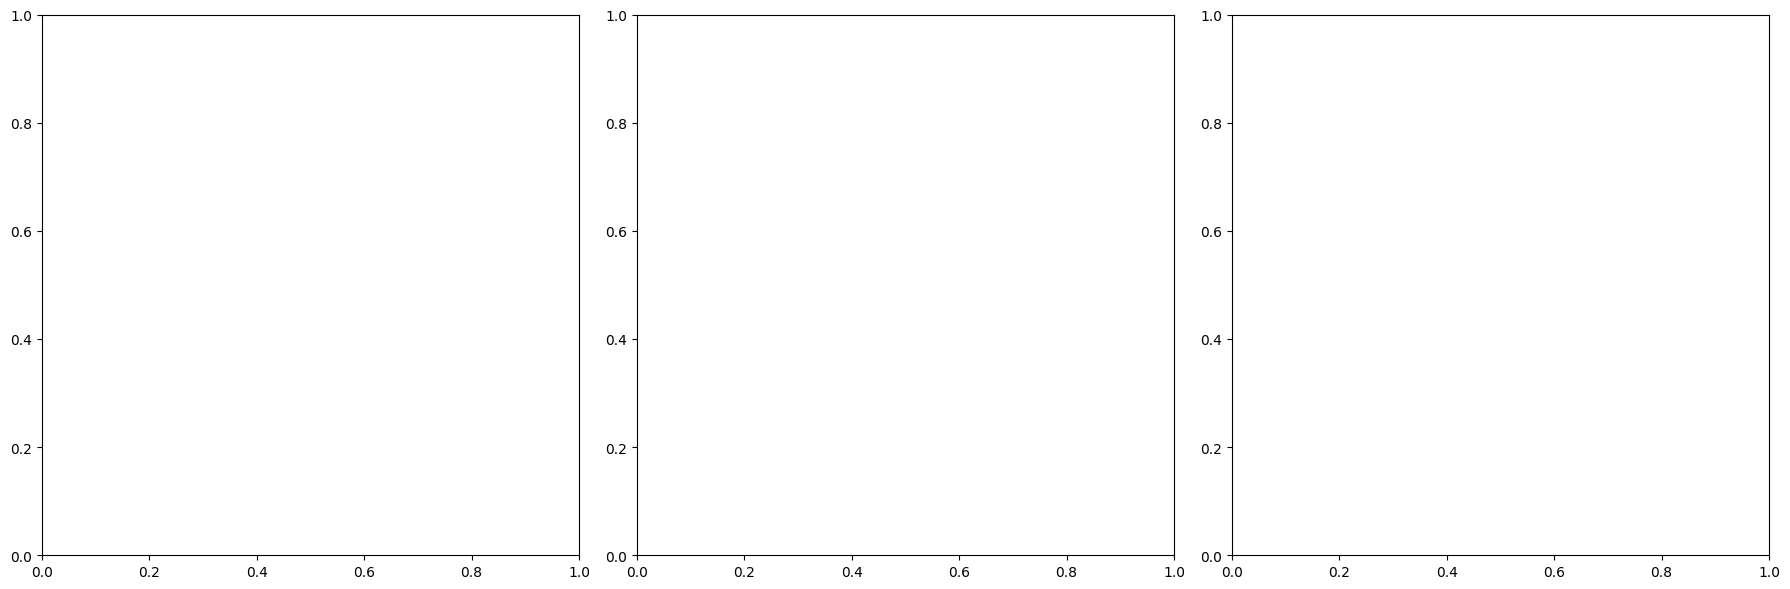

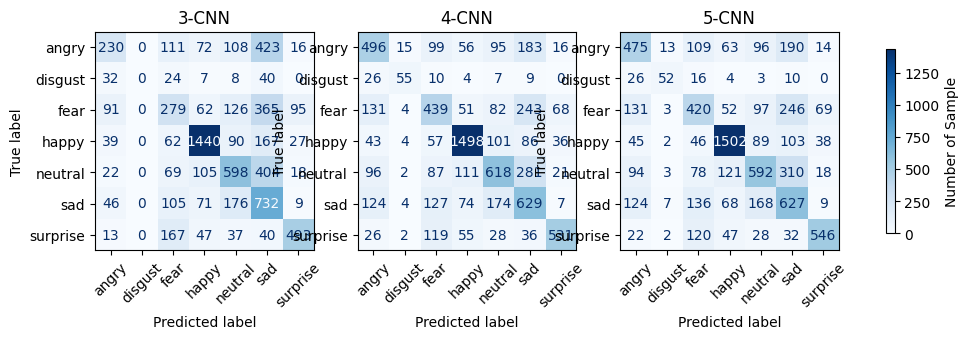

In [43]:
test_loader = val_loader
test_ds     = val_ds  
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1) Gather all true labels once: 
all_labels = []
for imgs, labels in test_loader:
    all_labels.extend(labels.cpu().numpy())

# 2) Prepare subplot grid
fig, axes = plt.subplots(1, 3, figsize=(18, 6), tight_layout=True)
models = {
    '3‑CNN': model_3,
    '4‑CNN': model,
    '5‑CNN': model_5,
}
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=100)
for ax, (name, m) in zip(axes, models.items()):
    m.to(device); m.eval()
    all_preds = []
    with torch.no_grad():
        for imgs, _ in val_loader:
            imgs = imgs.to(device)
            out  = m(imgs)
            preds= out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=train_ds.classes
    )
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45, colorbar=False)
    #disp.colorbar(axes[0].images[0], ax=axes, shrink=0.6, label='样本数')
    ax.set_title(name)

fig.colorbar(axes[0].images[0], ax=axes, shrink=0.6, label='Number of Sample')
# plt.tight_layout()
plt.show()

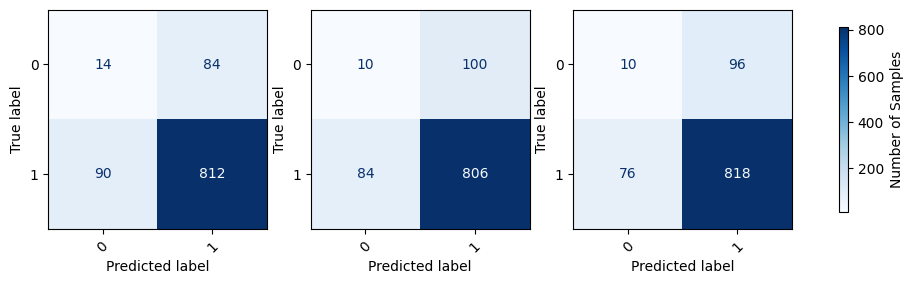

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=100)
for ax, (name, m) in zip(axes, models.items()):
    actual = np.random.binomial(1,.9,size = 1000)
    predicted = np.random.binomial(1,.9,size = 1000)
    cm = confusion_matrix(actual, predicted)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
    )
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45, colorbar=False)
fig.colorbar(axes[0].images[0], ax=axes, shrink=0.6, label='Number of Samples')
# plt.tight_layout()
plt.show()